In [55]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [113]:
df = pd.read_csv("nasa1.csv", index_col='Tanggal', parse_dates=True)
df.index.freq = 'D'

In [114]:
df.head

<bound method NDFrame.head of              Suhu  Kelembaban  Curah_Hujan
Tanggal                                   
2011-01-01  26.02       81.94        10.95
2011-01-02  25.93       84.81         6.97
2011-01-03  26.10       80.88         4.85
2011-01-04  25.73       80.56         9.94
2011-01-05  25.60       84.00         5.04
...           ...         ...          ...
2024-10-27  27.44       79.94         2.33
2024-10-28  27.52       79.69         1.27
2024-10-29  27.20       80.50         1.39
2024-10-30  27.35       79.31         1.97
2024-10-31  27.82       75.31         0.41

[5053 rows x 3 columns]>

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5053 entries, 2011-01-01 to 2024-10-31
Freq: D
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Suhu         5050 non-null   float64
 1   Kelembaban   5050 non-null   float64
 2   Curah_Hujan  5050 non-null   float64
dtypes: float64(3)
memory usage: 157.9 KB


In [116]:
df.describe()

Suhu   Kelembaban  Curah_Hujan
count  5050.000000  5050.000000  5050.000000
mean     26.990713    79.178727     6.194432
std       0.826380     4.462853    10.158024
min      24.370000    63.690000     0.000000
25%      26.410000    76.250000     0.740000
50%      26.950000    79.250000     2.665000
75%      27.550000    82.250000     7.060000
max      30.070000    92.000000   149.120000

In [117]:
# Mengisi data kosong dengan mean dari masing-masing kolom
cols_to_fill = ['Curah_Hujan', 'Kelembaban', 'Suhu']  # Kolom target

for col in cols_to_fill:
    mean_value = df[col].mean()  # Menghitung mean dari kolom
    df[col] = df[col].fillna(mean_value)  # Mengisi nilai kosong dengan mean

print(df)

             Suhu  Kelembaban  Curah_Hujan
Tanggal                                   
2011-01-01  26.02       81.94        10.95
2011-01-02  25.93       84.81         6.97
2011-01-03  26.10       80.88         4.85
2011-01-04  25.73       80.56         9.94
2011-01-05  25.60       84.00         5.04
...           ...         ...          ...
2024-10-27  27.44       79.94         2.33
2024-10-28  27.52       79.69         1.27
2024-10-29  27.20       80.50         1.39
2024-10-30  27.35       79.31         1.97
2024-10-31  27.82       75.31         0.41

[5053 rows x 3 columns]


In [118]:
df.describe()

Suhu   Kelembaban  Curah_Hujan
count  5053.000000  5053.000000  5053.000000
mean     26.990713    79.178727     6.194432
std       0.826134     4.461528    10.155008
min      24.370000    63.690000     0.000000
25%      26.410000    76.250000     0.740000
50%      26.950000    79.250000     2.670000
75%      27.550000    82.250000     7.060000
max      30.070000    92.000000   149.120000

In [150]:
from sklearn.preprocessing import StandardScaler
# === Step 2: Standardization ===
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[['Suhu']])

# === Step 3: Create Sequences for LSTM ===
sequence_length = 700  # Menggunakan 60 hari terakhir untuk memprediksi
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i])
    y.append(data_scaled[i])

X, y = np.array(X), np.array(y)

# Split data (80% train, 20% test)
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [151]:
# === Step 4: Build LSTM Model ===
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Output layer untuk satu langkah prediksi
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
123/123 [==============================] - 80s 613ms/step - loss: 0.4618 - val_loss: 0.4435
Epoch 2/100
123/123 [==============================] - 75s 613ms/step - loss: 0.3757 - val_loss: 0.3522
Epoch 3/100
123/123 [==============================] - 75s 612ms/step - loss: 0.3369 - val_loss: 0.3388
Epoch 4/100
123/123 [==============================] - 76s 619ms/step - loss: 0.3152 - val_loss: 0.3160
Epoch 5/100
123/123 [==============================] - 77s 628ms/step - loss: 0.2999 - val_loss: 0.3029
Epoch 6/100
123/123 [==============================] - 77s 629ms/step - loss: 0.2982 - val_loss: 0.3063
Epoch 7/100
123/123 [==============================] - 77s 629ms/step - loss: 0.2957 - val_loss: 0.3158
Epoch 8/100
123/123 [==============================] - 77s 629ms/step - loss: 0.2949 - val_loss: 0.2998
Epoch 9/100
123/123 [==============================] - 77s 627ms/step - loss: 0.2967 - val_loss: 0.3051
Epoch 10/100
123/123 [==============================] - 77s 630m

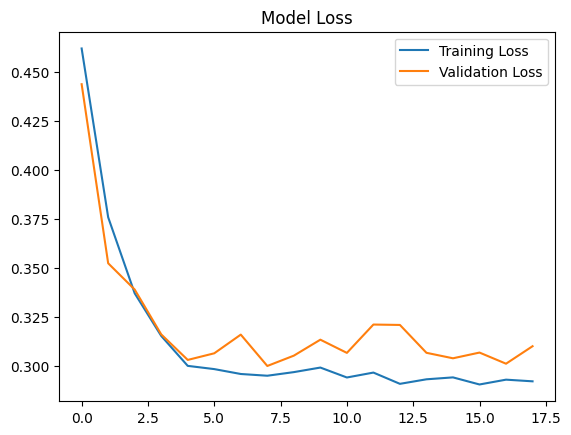

In [152]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [153]:
forecast = []
current_sequence = data_scaled[-sequence_length:].copy()  # Ambil sequence terakhir dari data

for i in range(365):
    # Prediksi langkah berikutnya
    pred = model.predict(current_sequence[np.newaxis, :, :], verbose=0)
    forecast.append(pred.flatten()[0])

    # Teacher forcing: tambahkan nilai aktual jika tersedia
    if i < len(y_test):
        current_sequence = np.append(current_sequence[1:], y_test[i]).reshape(-1, 1)
    else:
        current_sequence = np.append(current_sequence[1:], pred).reshape(-1, 1)

# Inverse scaling
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))



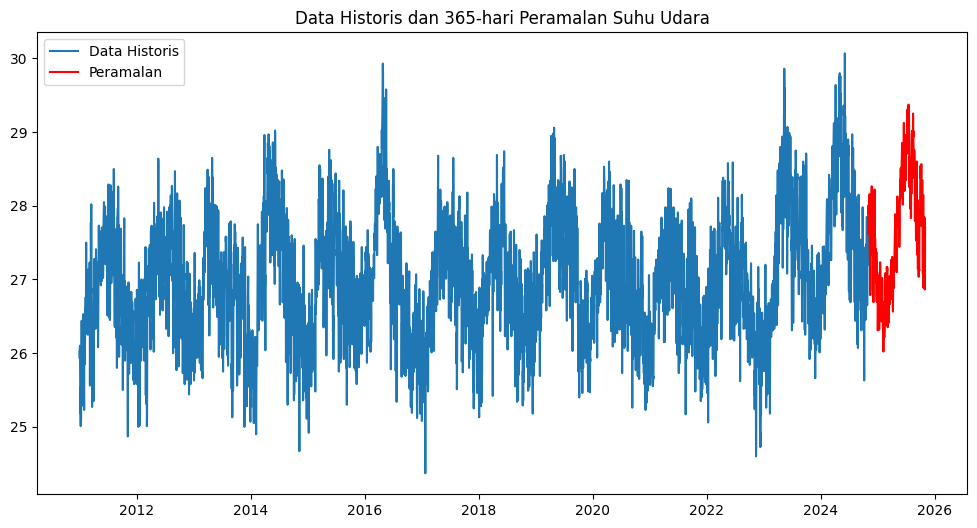

In [169]:
# === Step 6: Visualize Results ===
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=365)
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast.flatten()})
forecast_df.set_index('Date', inplace=True)

# Combine historical data and forecast
df_combined = pd.concat([df, forecast_df])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_combined.index, df_combined['Suhu'], label='Data Historis')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Peramalan', color='red')
plt.title('Data Historis dan 365-hari Peramalan Suhu Udara')
plt.legend()
plt.show()

In [161]:
forecast_df

Forecast
Date                 
2024-11-01  27.622120
2024-11-02  28.004936
2024-11-03  27.960382
2024-11-04  27.877375
2024-11-05  27.973124
...               ...
2025-10-27  27.839745
2025-10-28  27.450315
2025-10-29  26.864367
2025-10-30  27.004841
2025-10-31  27.705336

[365 rows x 1 columns]

In [164]:
#forecast_df.to_csv('D:/cool/TA/data/forecast_results.csv', index=False)

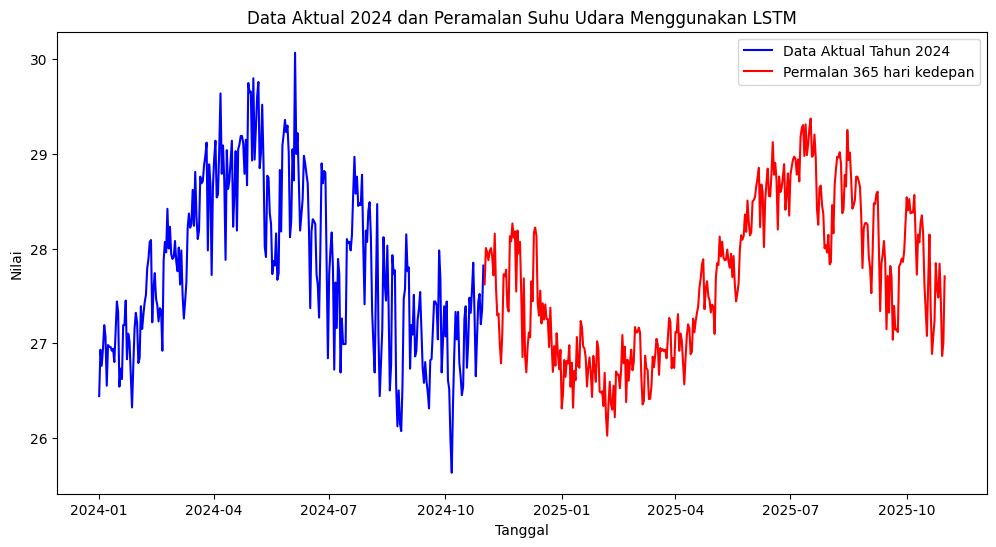

In [168]:
# Step 1: Filter data aktual tahun 2024
df_2024 = df[df.index.year == 2024]

# Step 2: Gabungkan data aktual tahun 2024 dan hasil forecast
# Data aktual berhenti di akhir tahun 2023, sehingga prediksi forecast dimulai di tahun 2024
combined_forecast = pd.concat([df_2024, forecast_df], axis=0)

# Step 3: Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(df_2024.index, df_2024.iloc[:, 0], label="Data Aktual Tahun 2024", color='blue')
plt.plot(forecast_df.index, forecast_df['Forecast'], label="Permalan 365 hari kedepan", color='red')

# Tambahkan judul dan label
plt.title("Data Aktual 2024 dan Peramalan Suhu Udara Menggunakan LSTM")
plt.xlabel("Tanggal")
plt.ylabel("Nilai")
plt.legend()

# Tampilkan plot
plt.show()

In [119]:
# === Step 2: Scaling Data ===
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df[['Suhu']])

# === Step 3: Create Sequences for LSTM ===
sequence_length =   # Menggunakan 30 hari terakhir untuk memprediksi
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i])
    y.append(data_scaled[i])

X, y = np.array(X), np.array(y)

# Split data (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
# Create the LSTM model
model = Sequential()

# Add LSTM layers with dropout
model.add(LSTM(units=128, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Add a dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [126]:
# === Step 4: Build LSTM Model ===
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(365)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [127]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
126/126 [==============================] - 9s 36ms/step - loss: 0.0407 - val_loss: 0.0115
Epoch 2/100
126/126 [==============================] - 4s 29ms/step - loss: 0.0132 - val_loss: 0.0098
Epoch 3/100
126/126 [==============================] - 4s 28ms/step - loss: 0.0115 - val_loss: 0.0095
Epoch 4/100
126/126 [==============================] - 4s 29ms/step - loss: 0.0109 - val_loss: 0.0087
Epoch 5/100
126/126 [==============================] - 4s 29ms/step - loss: 0.0101 - val_loss: 0.0082
Epoch 6/100
126/126 [==============================] - 4s 29ms/step - loss: 0.0093 - val_loss: 0.0075
Epoch 7/100
126/126 [==============================] - 3s 27ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 8/100
126/126 [==============================] - 4s 28ms/step - loss: 0.0088 - val_loss: 0.0080
Epoch 9/100
126/126 [==============================] - 3s 28ms/step - loss: 0.0082 - val_loss: 0.0071
Epoch 10/100
126/126 [==============================] - 3s 27ms/step - loss: 0.007

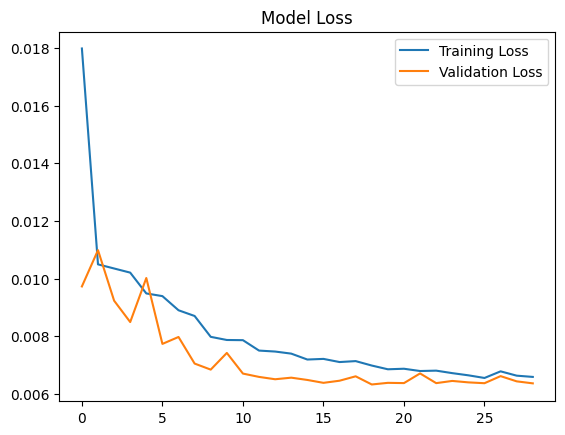

In [123]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [137]:
# Recursive Forecasting
forecast = []
current_sequence = last_sequence.copy()

for _ in range(365):
    pred = model.predict(current_sequence[np.newaxis, :, :], verbose=0)
    forecast.append(pred.flatten()[0])
    # Update sequence with the predicted value
    current_sequence = np.append(current_sequence[1:], pred).reshape(-1, 1)

# Inverse scaling
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Create forecast dataframe
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=365)
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast.flatten()})
forecast_df.set_index('Date', inplace=True)


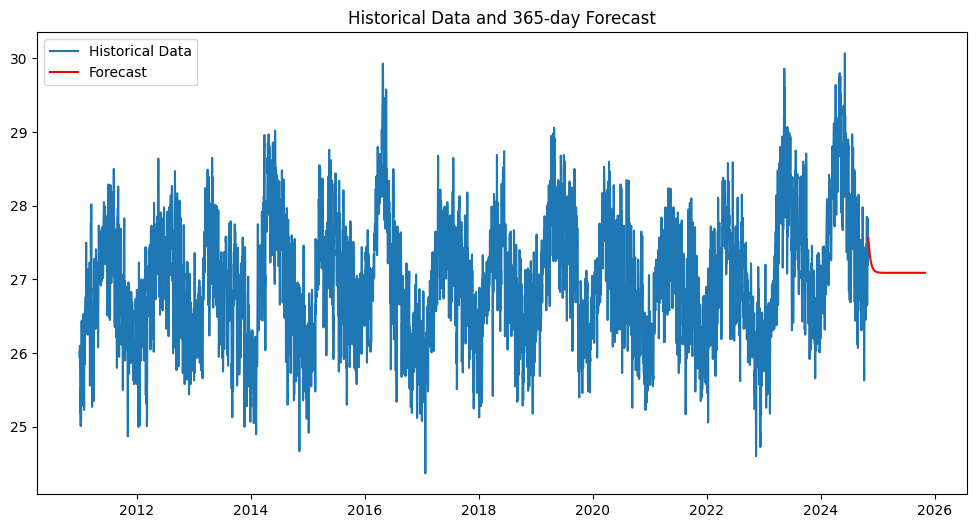

In [138]:
# Combine historical data and forecast
df_combined = pd.concat([df, forecast_df])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_combined.index, df_combined['Suhu'], label='Historical Data')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.title('Historical Data and 365-day Forecast')
plt.legend()
plt.show()

In [128]:
# === Step 5: Forecast 365 Days Ahead ===
def forecast_lstm_direct(model, last_sequence):
    forecast_scaled = model.predict(last_sequence[np.newaxis, :, :], verbose=0)
    return forecast_scaled.flatten()

# Menggunakan data terakhir dari dataset untuk memulai forecast
last_sequence = data_scaled[-sequence_length:]
forecast_scaled = forecast_lstm_direct(model, last_sequence)

# Inverse scaling
forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1))

In [133]:
forecast_scaled

array([0.56025803, 0.5594156 , 0.5626263 , 0.5584918 , 0.5614729 ,
       0.5604276 , 0.5570596 , 0.5587357 , 0.5588226 , 0.5610838 ,
       0.55803055, 0.55810547, 0.56118685, 0.55826336, 0.5561854 ,
       0.5561808 , 0.5572159 , 0.5640203 , 0.5560561 , 0.5598853 ,
       0.55558914, 0.56121033, 0.5605089 , 0.560815  , 0.5570475 ,
       0.5612971 , 0.5609874 , 0.5617394 , 0.55798936, 0.5649295 ,
       0.5583565 , 0.55614185, 0.5628422 , 0.55729526, 0.5574609 ,
       0.56212413, 0.55604464, 0.562397  , 0.55822796, 0.5574412 ,
       0.56026775, 0.56129   , 0.5600682 , 0.55983686, 0.55902004,
       0.5620529 , 0.56186885, 0.55988   , 0.5612136 , 0.56010395,
       0.5586245 , 0.55454797, 0.5611744 , 0.56174076, 0.5563968 ,
       0.56924343, 0.5557452 , 0.55608064, 0.55975485, 0.56085783,
       0.5639009 , 0.559306  , 0.5578713 , 0.5624678 , 0.5616769 ,
       0.55958736, 0.5576198 , 0.55291194, 0.5569308 , 0.56161803,
       0.5566007 , 0.5560359 , 0.5608487 , 0.56025517, 0.55792

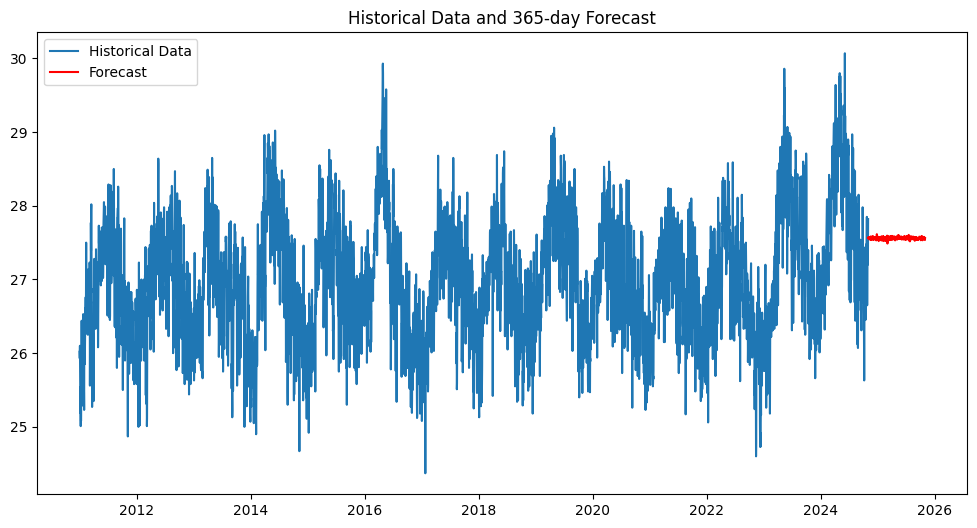

In [130]:
# === Step 6: Visualize Results ===
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=365)
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast.flatten()})
forecast_df.set_index('Date', inplace=True)

# Combine historical data and forecast
df_combined = pd.concat([df, forecast_df])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_combined.index, df_combined['Suhu'], label='Historical Data')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.title('Historical Data and 365-day Forecast')
plt.legend()
plt.show()

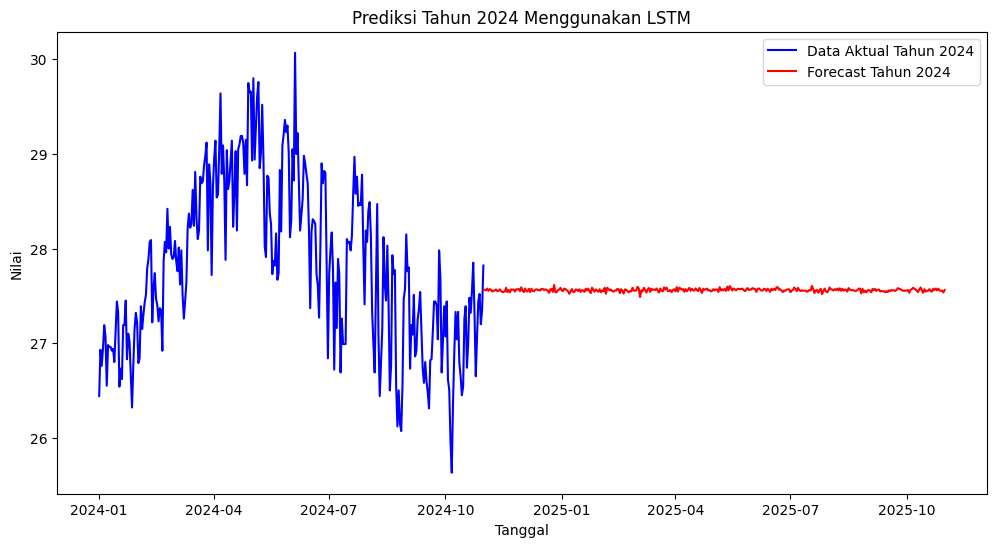

In [132]:
# Step 1: Filter data aktual tahun 2024
df_2024 = df[df.index.year == 2024]

# Step 2: Gabungkan data aktual tahun 2024 dan hasil forecast
# Data aktual berhenti di akhir tahun 2023, sehingga prediksi forecast dimulai di tahun 2024
combined_forecast = pd.concat([df_2024, forecast_df], axis=0)

# Step 3: Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(df_2024.index, df_2024.iloc[:, 0], label="Data Aktual Tahun 2024", color='blue')
plt.plot(forecast_df.index, forecast_df['Forecast'], label="Forecast Tahun 2024", color='red')

# Tambahkan judul dan label
plt.title("Prediksi Tahun 2024 Menggunakan LSTM")
plt.xlabel("Tanggal")
plt.ylabel("Nilai")
plt.legend()

# Tampilkan plot
plt.show()

In [62]:
n_cols = 3
cols = list(df.loc[:, ['Suhu', 'Kelembaban', 'Curah_Hujan']])
dataset = df[cols]
dataset = pd.DataFrame(dataset)
data = dataset.values

data.shape

(5053, 3)

In [63]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))

In [64]:
train_size = int(len(data) * 0.9)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 4547 Test Size : 506


In [65]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(4547, 3)

In [96]:
# Creating a Training set with 60 time-steps
x_train = []
y_train = []
time_steps = 365
n_cols = 3

for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i, :n_cols])
    y_train.append(train_data[i, :n_cols])

In [97]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [98]:
# Reshaping the input to (n_samples, time_steps, n_feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_cols))
x_train.shape , y_train.shape

((4182, 365, 3), (4182, 3))

In [99]:
model2 = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], n_cols)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(n_cols)
])

model2.compile(optimizer= 'adam', loss= 'mse' , metrics= "mean_absolute_error")

In [100]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 365, 50)           10800     
                                                                 
 lstm_7 (LSTM)               (None, 64)                29440     
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 3)                 51        
                                                                 
Total params: 42,899
Trainable params: 42,899
Non-trainable params: 0
_________________________________________________________________


In [101]:
# Fitting the LSTM to the Training set
history2 = model2.fit(x_train, y_train, epochs= 100, batch_size= 32)

Epoch 1/100
131/131 [==============================] - 39s 267ms/step - loss: 0.0157 - mean_absolute_error: 0.0885
Epoch 2/100
131/131 [==============================] - 36s 278ms/step - loss: 0.0102 - mean_absolute_error: 0.0729
Epoch 3/100
131/131 [==============================] - 38s 293ms/step - loss: 0.0098 - mean_absolute_error: 0.0720
Epoch 4/100
131/131 [==============================] - 37s 282ms/step - loss: 0.0092 - mean_absolute_error: 0.0690
Epoch 5/100
131/131 [==============================] - 36s 271ms/step - loss: 0.0087 - mean_absolute_error: 0.0675
Epoch 6/100
131/131 [==============================] - 37s 284ms/step - loss: 0.0084 - mean_absolute_error: 0.0661
Epoch 7/100
131/131 [==============================] - 37s 279ms/step - loss: 0.0083 - mean_absolute_error: 0.0659
Epoch 8/100
131/131 [==============================] - 37s 286ms/step - loss: 0.0081 - mean_absolute_error: 0.0645
Epoch 9/100
131/131 [==============================] - 38s 289ms/step - loss: 0.

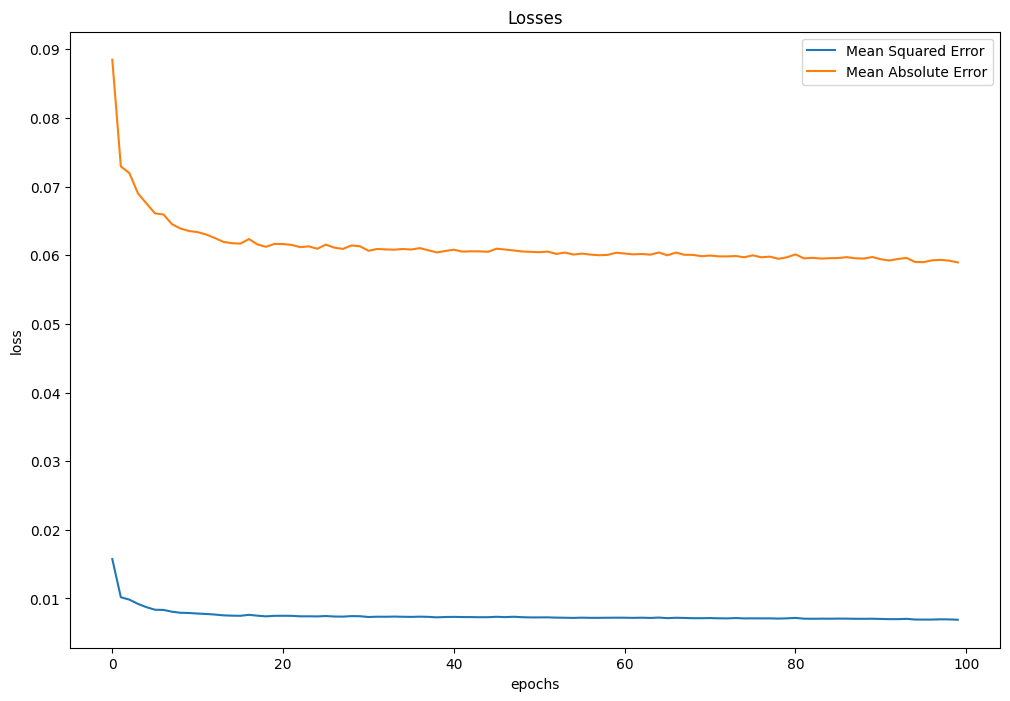

In [102]:
plt.figure(figsize=(12, 8))
plt.plot(history2.history["loss"])
plt.plot(history2.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [103]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 365
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 3

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [104]:
x_test.shape , y_test.shape

((506, 365, 3), (506, 3))

In [105]:
# Get Prediction
predictions = model2.predict(x_test)

16/16 [==============================] - 5s 86ms/step


In [106]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)

In [107]:
RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

37.31

In [108]:
from datetime import timedelta
def insert_end(Xin, new_input):
    timestep = 365
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [ ]:
future = 100
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future):
    out = model2.predict(Xin, batch_size=5)
    forcast.append(out[0]) 
    print(forcast)
    Xin = insert_end(Xin, out[0, 0]) 
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 [==============================] - 0s 38ms/step
[array([0.51478213, 0.56999797, 0.04062144], dtype=float32)]
1/1 [==============================] - 0s 66ms/step
[array([0.51478213, 0.56999797, 0.04062144], dtype=float32), array([0.4603121 , 0.54278356, 0.19808424], dtype=float32)]
1/1 [==============================] - 0s 60ms/step
[array([0.51478213, 0.56999797, 0.04062144], dtype=float32), array([0.4603121 , 0.54278356, 0.19808424], dtype=float32), array([0.3923664 , 0.58643407, 0.11796276], dtype=float32)]
1/1 [==============================] - 0s 60ms/step
[array([0.51478213, 0.56999797, 0.04062144], dtype=float32), array([0.4603121 , 0.54278356, 0.19808424], dtype=float32), array([0.3923664 , 0.58643407, 0.11796276], dtype=float32), array([0.44376957, 0.55074733, 0.16132519], dtype=float32)]
1/1 [==============================] - 0s 60ms/step
[array([0.51478213, 0.56999797, 0.04062144], dtype=float32), array([0.4603121 , 0.54278356, 0.19808424], dtype=float32), array([0.392366

In [110]:
forcasted_output = np.asanyarray(forcast)   
forcasted_output = scaler.inverse_transform(forcasted_output)

In [111]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", 'Suhu', 'Kelembaban', 'Curah_Hujan'
df_result.head()

Date       Suhu  Kelembaban  Curah_Hujan
0 2024-10-31  27.304258   79.826645     6.057469
1 2024-11-01  26.993778   79.056206    29.538321
2 2024-11-02  26.606489   80.291954    17.590607
3 2024-11-03  26.899487   79.281662    24.056812
4 2024-11-04  26.967806   79.838661    23.287771

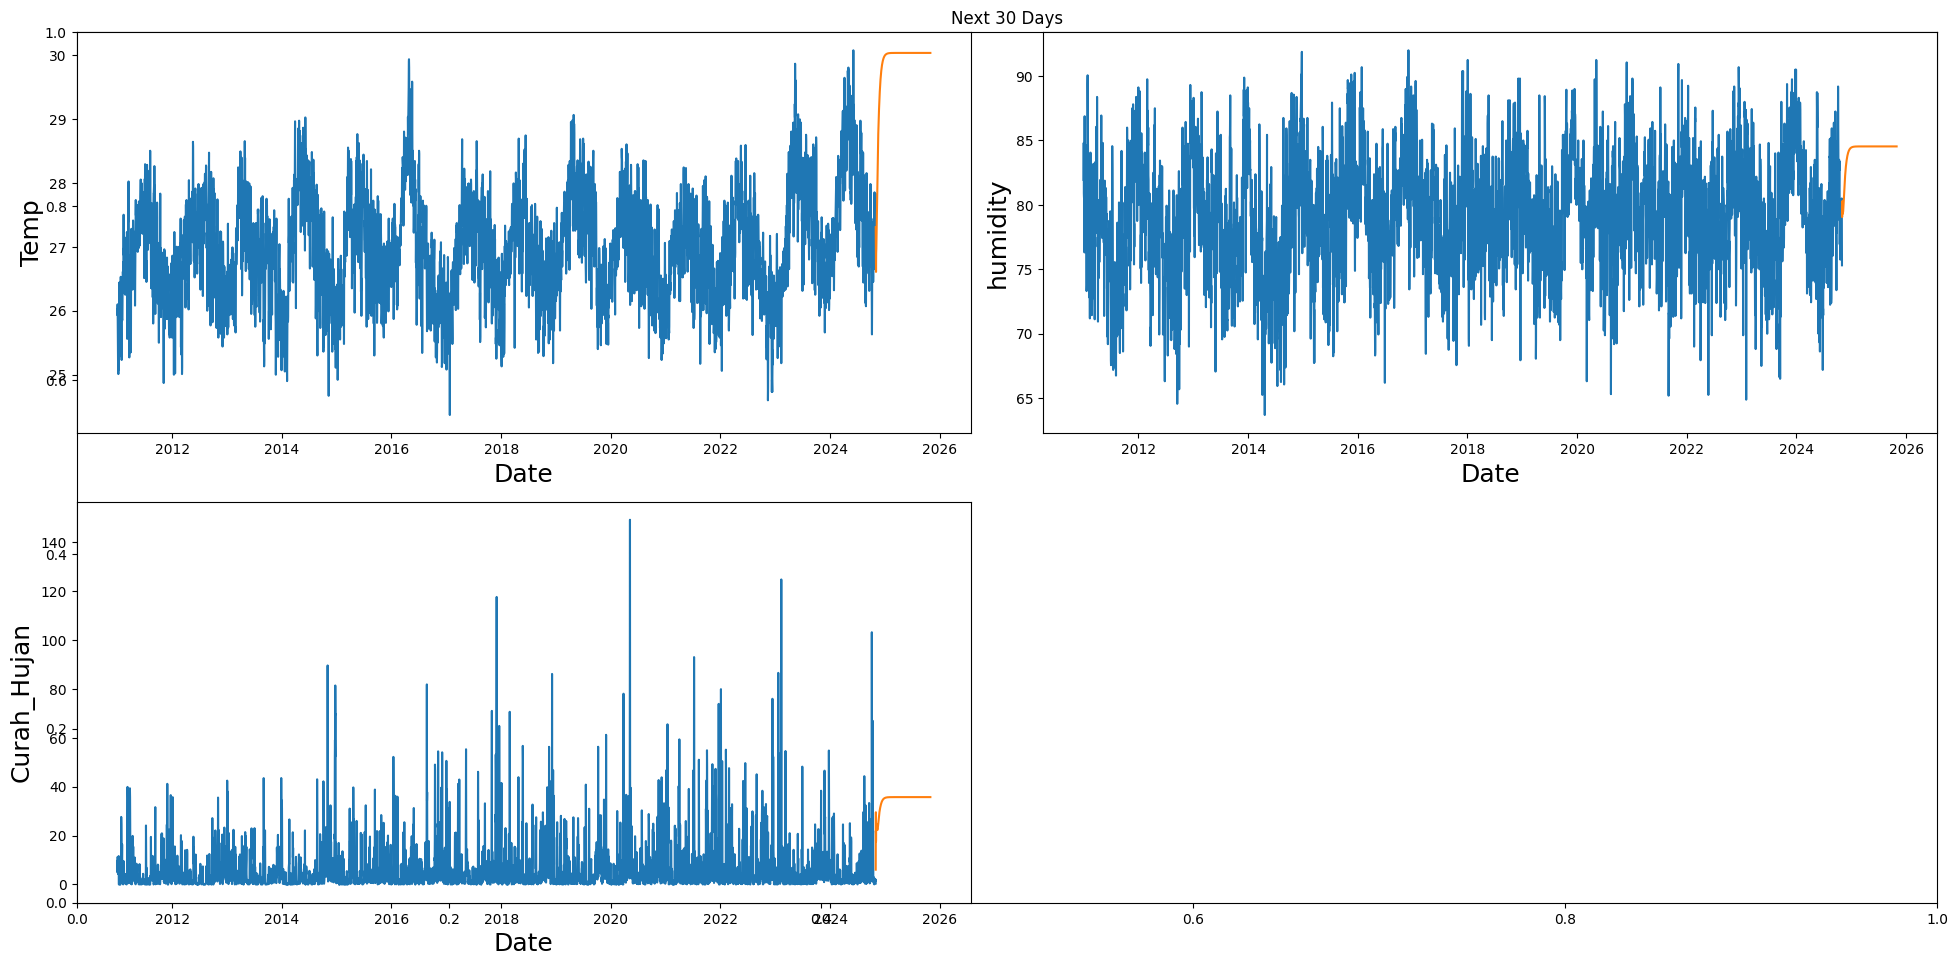

In [112]:
plt.figure(figsize=(20, 10))
plt.title('Next 30 Days')

plt.subplot(2, 2, 1)
plt.plot(df['Suhu'])
plt.plot(df_result.set_index('Date')[['Suhu']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Temp' ,fontsize=18)

plt.subplot(2, 2, 2)
plt.plot(df['Kelembaban'])
plt.plot(df_result.set_index('Date')[['Kelembaban']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('humidity' ,fontsize=18)

plt.subplot(2, 2, 3)
plt.plot(df['Curah_Hujan'])
plt.plot(df_result.set_index('Date')[['Curah_Hujan']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Curah_Hujan' ,fontsize=18)

plt.tight_layout()
plt.show()

In [17]:
dataset = df["Suhu"]
dataset = pd.DataFrame(dataset)

data = dataset.values

data.shape

(5053, 1)

In [46]:
data = df
# Pastikan kolom 'value' ada di data
values = data['Suhu'].values.reshape(-1, 1)

In [47]:
# 2. Normalize Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

In [48]:
# 3. Prepare Data for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

In [49]:
sequence_length = 100  # Bisa disesuaikan
X, y = create_sequences(scaled_values, sequence_length)

# Split Data (80% Train, 20% Test)
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [50]:
# 4. Build LSTM Model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 5. Train Model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
109/109 [==============================] - 14s 91ms/step - loss: 0.0194 - val_loss: 0.0093
Epoch 2/100
109/109 [==============================] - 9s 86ms/step - loss: 0.0113 - val_loss: 0.0089
Epoch 3/100
109/109 [==============================] - 9s 86ms/step - loss: 0.0109 - val_loss: 0.0088
Epoch 4/100
109/109 [==============================] - 10s 88ms/step - loss: 0.0105 - val_loss: 0.0083
Epoch 5/100
109/109 [==============================] - 10s 88ms/step - loss: 0.0097 - val_loss: 0.0081
Epoch 6/100
109/109 [==============================] - 10s 96ms/step - loss: 0.0095 - val_loss: 0.0078
Epoch 7/100
109/109 [==============================] - 10s 92ms/step - loss: 0.0096 - val_loss: 0.0076
Epoch 8/100
109/109 [==============================] - 10s 90ms/step - loss: 0.0090 - val_loss: 0.0074
Epoch 9/100
109/109 [==============================] - 10s 90ms/step - loss: 0.0084 - val_loss: 0.0070
Epoch 10/100
109/109 [==============================] - 10s 94ms/step - los

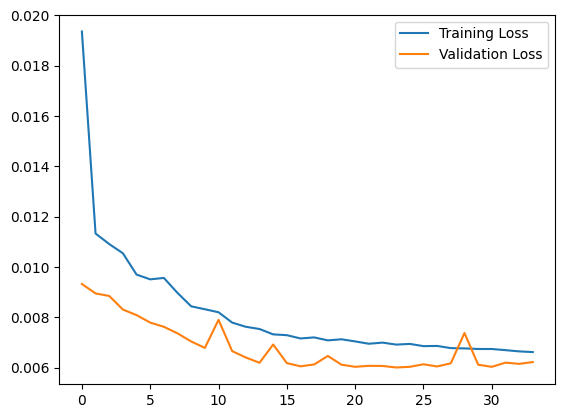

In [51]:
# 6. Evaluate Model
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [52]:
# 7. Predict 365 Days Ahead
def predict_future(model, data, steps):
    future_predictions = []
    input_sequence = data[-sequence_length:].reshape(1, sequence_length, 1)

    for _ in range(steps):
        next_value = model.predict(input_sequence, verbose=0)
        future_predictions.append(next_value[0, 0])
        # Update input sequence
        input_sequence = np.append(input_sequence[:, 1:, :], [[[next_value[0, 0]]]], axis=1)

    return np.array(future_predictions)

future_predictions = predict_future(model, scaled_values, 365)

# Inverse Scale Predictions
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1))

In [53]:
future_predictions

array([[27.599237],
       [27.45372 ],
       [27.416637],
       [27.391521],
       [27.3771  ],
       [27.370115],
       [27.367828],
       [27.368324],
       [27.370266],
       [27.37279 ],
       [27.375347],
       [27.377625],
       [27.37948 ],
       [27.380873],
       [27.381813],
       [27.382364],
       [27.382593],
       [27.38257 ],
       [27.382364],
       [27.382027],
       [27.381609],
       [27.381144],
       [27.380661],
       [27.38017 ],
       [27.37969 ],
       [27.379225],
       [27.378777],
       [27.378347],
       [27.377937],
       [27.37754 ],
       [27.377157],
       [27.376787],
       [27.376423],
       [27.37607 ],
       [27.375721],
       [27.37538 ],
       [27.375042],
       [27.374708],
       [27.374376],
       [27.374048],
       [27.373724],
       [27.3734  ],
       [27.373083],
       [27.372766],
       [27.372456],
       [27.372145],
       [27.371841],
       [27.371536],
       [27.371237],
       [27.370941],


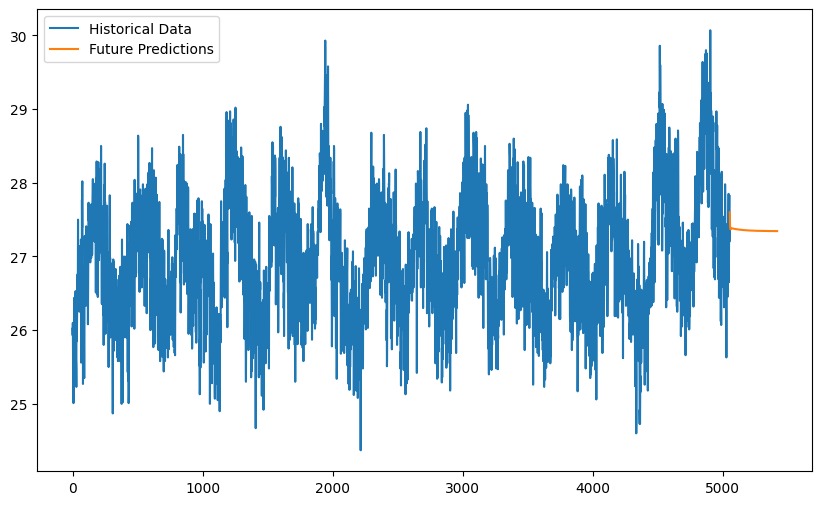

In [54]:
# 8. Plot Results
plt.figure(figsize=(10, 6))
plt.plot(range(len(values)), values, label='Historical Data')
plt.plot(range(len(values), len(values) + 365), future_predictions, label='Future Predictions')
plt.legend()
plt.show()

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

In [10]:
# 90% to Train , 10% to Test
train_size = int(len(data)*.9)
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = scaled_data[ :train_size , 0:1 ]
test_data = scaled_data[ train_size-60: , 0:1 ]

Train Size : 4547 Test Size : 506


In [11]:
train_data.shape, test_data.shape

((4547, 1), (566, 1))

In [12]:
# Creating a Training set with 60 time-steps and 1 output
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [13]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [14]:
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [15]:
x_train.shape , y_train.shape

((4487, 60, 1), (4487,))

In [18]:
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], 1)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= "mean_absolute_error")

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 42,465
Trainable params: 42,465
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Fitting the LSTM to the Training set
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100
141/141 [==============================] - 13s 50ms/step - loss: 0.0138 - mean_absolute_error: 0.0890
Epoch 2/100
141/141 [==============================] - 7s 50ms/step - loss: 0.0088 - mean_absolute_error: 0.0745
Epoch 3/100
141/141 [==============================] - 7s 49ms/step - loss: 0.0082 - mean_absolute_error: 0.0719
Epoch 4/100
141/141 [==============================] - 7s 48ms/step - loss: 0.0076 - mean_absolute_error: 0.0689
Epoch 5/100
141/141 [==============================] - 8s 60ms/step - loss: 0.0074 - mean_absolute_error: 0.0676
Epoch 6/100
141/141 [==============================] - 7s 51ms/step - loss: 0.0070 - mean_absolute_error: 0.0662
Epoch 7/100
141/141 [==============================] - 8s 59ms/step - loss: 0.0066 - mean_absolute_error: 0.0641
Epoch 8/100
141/141 [==============================] - 7s 50ms/step - loss: 0.0063 - mean_absolute_error: 0.0627
Epoch 9/100
141/141 [==============================] - 8s 60ms/step - loss: 0.0063 - mean_absol

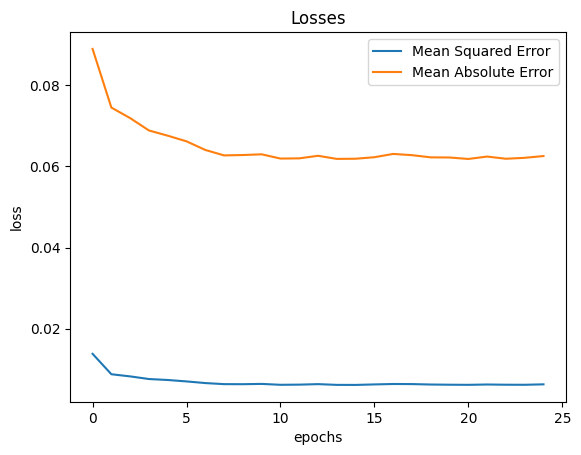

In [21]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [22]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [23]:
x_test.shape , y_test.shape

((506, 60, 1), (506,))

In [24]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

16/16 [==============================] - 3s 23ms/step


(506, 1)

In [25]:
#inverse y_test scaling
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

0.05

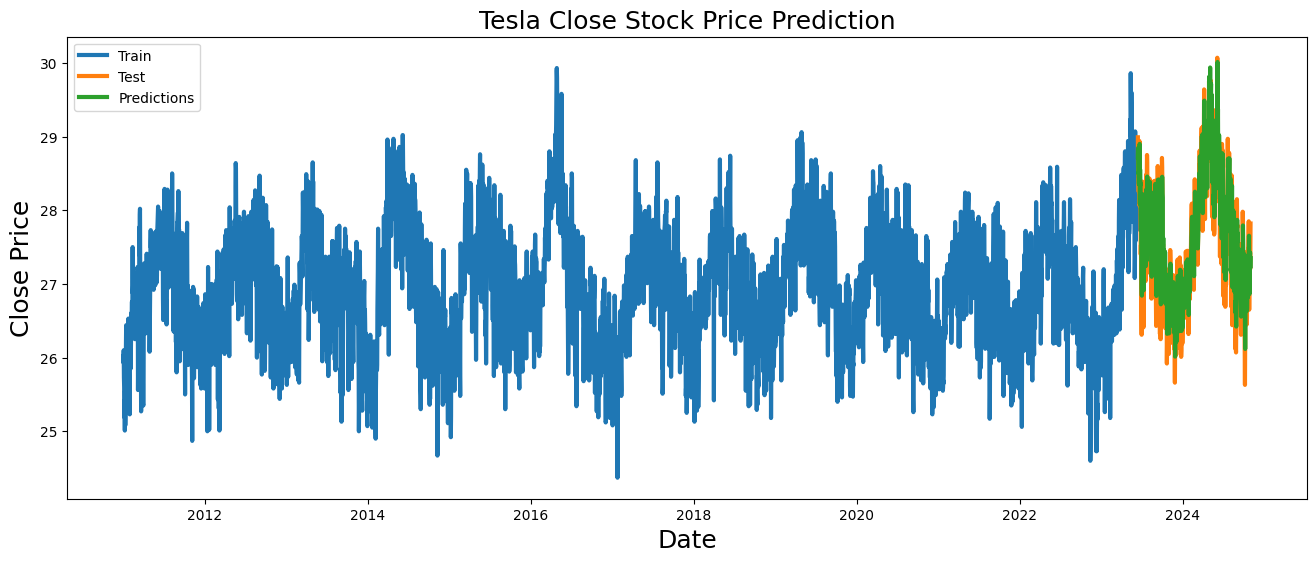

In [27]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Tesla Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['Suhu'], linewidth= 3)
plt.plot(test['Suhu'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

In [28]:
from datetime import timedelta

In [29]:
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [30]:
future = 30
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0, 0]) 
    print(forcast)
    Xin = insert_end(Xin, out[0, 0]) 
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 [==============================] - 0s 30ms/step
[0.5228413]
1/1 [==============================] - 0s 51ms/step
[0.5228413, 0.5205501]
1/1 [==============================] - 0s 52ms/step
[0.5228413, 0.5205501, 0.5208662]
1/1 [==============================] - 0s 53ms/step
[0.5228413, 0.5205501, 0.5208662, 0.5219745]
1/1 [==============================] - 0s 51ms/step
[0.5228413, 0.5205501, 0.5208662, 0.5219745, 0.523447]
1/1 [==============================] - 0s 48ms/step
[0.5228413, 0.5205501, 0.5208662, 0.5219745, 0.523447, 0.5251216]
1/1 [==============================] - 0s 50ms/step
[0.5228413, 0.5205501, 0.5208662, 0.5219745, 0.523447, 0.5251216, 0.5269186]
1/1 [==============================] - 0s 48ms/step
[0.5228413, 0.5205501, 0.5208662, 0.5219745, 0.523447, 0.5251216, 0.5269186, 0.5287936]
1/1 [==============================] - 0s 50ms/step
[0.5228413, 0.5205501, 0.5208662, 0.5219745, 0.523447, 0.5251216, 0.5269186, 0.5287936, 0.5307189]
1/1 [============================

In [31]:
time

[Timestamp('2024-10-31 00:00:00'),
 Timestamp('2024-11-01 00:00:00'),
 Timestamp('2024-11-02 00:00:00'),
 Timestamp('2024-11-03 00:00:00'),
 Timestamp('2024-11-04 00:00:00'),
 Timestamp('2024-11-05 00:00:00'),
 Timestamp('2024-11-06 00:00:00'),
 Timestamp('2024-11-07 00:00:00'),
 Timestamp('2024-11-08 00:00:00'),
 Timestamp('2024-11-09 00:00:00'),
 Timestamp('2024-11-10 00:00:00'),
 Timestamp('2024-11-11 00:00:00'),
 Timestamp('2024-11-12 00:00:00'),
 Timestamp('2024-11-13 00:00:00'),
 Timestamp('2024-11-14 00:00:00'),
 Timestamp('2024-11-15 00:00:00'),
 Timestamp('2024-11-16 00:00:00'),
 Timestamp('2024-11-17 00:00:00'),
 Timestamp('2024-11-18 00:00:00'),
 Timestamp('2024-11-19 00:00:00'),
 Timestamp('2024-11-20 00:00:00'),
 Timestamp('2024-11-21 00:00:00'),
 Timestamp('2024-11-22 00:00:00'),
 Timestamp('2024-11-23 00:00:00'),
 Timestamp('2024-11-24 00:00:00'),
 Timestamp('2024-11-25 00:00:00'),
 Timestamp('2024-11-26 00:00:00'),
 Timestamp('2024-11-27 00:00:00'),
 Timestamp('2024-11-

In [32]:
forcasted_output = np.asanyarray(forcast)   
forcasted_output = forcasted_output.reshape(-1, 1) 
forcasted_output = scaler.inverse_transform(forcasted_output) 

In [33]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"

In [34]:
df_result

Date  Forecasted
0  2024-10-31   27.350195
1  2024-11-01   27.337135
2  2024-11-02   27.338936
3  2024-11-03   27.345253
4  2024-11-04   27.353647
5  2024-11-05   27.363192
6  2024-11-06   27.373436
7  2024-11-07   27.384123
8  2024-11-08   27.395098
9  2024-11-09   27.406252
10 2024-11-10   27.417507
11 2024-11-11   27.428806
12 2024-11-12   27.440107
13 2024-11-13   27.451385
14 2024-11-14   27.462624
15 2024-11-15   27.473816
16 2024-11-16   27.484964
17 2024-11-17   27.496071
18 2024-11-18   27.507143
19 2024-11-19   27.518196
20 2024-11-20   27.529230
21 2024-11-21   27.540266
22 2024-11-22   27.551306
23 2024-11-23   27.562359
24 2024-11-24   27.573439
25 2024-11-25   27.584543
26 2024-11-26   27.595684
27 2024-11-27   27.606867
28 2024-11-28   27.618090
29 2024-11-29   27.629358

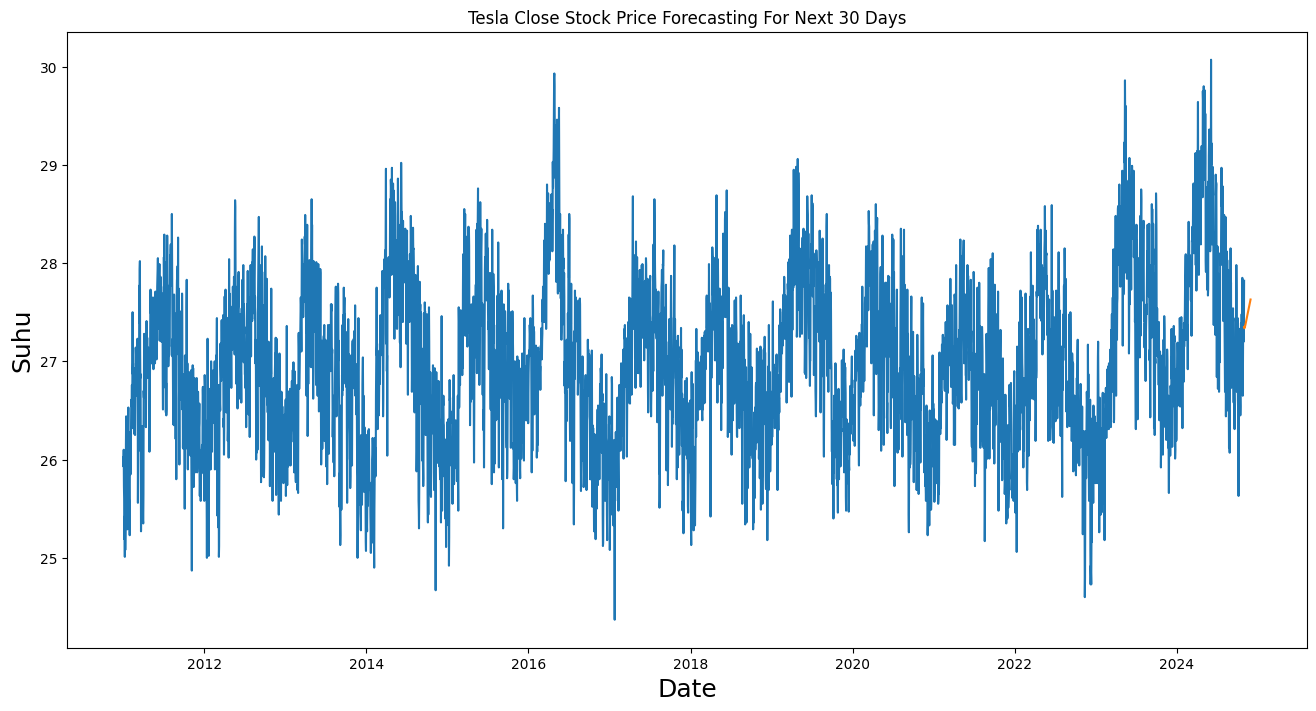

In [36]:
plt.figure(figsize=(16, 8))
plt.title('Tesla Close Stock Price Forecasting For Next 30 Days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Suhu' ,fontsize=18)
plt.plot(df['Suhu'])
plt.plot(df_result.set_index('Date')[['Forecasted']])

In [8]:
n_cols = 1
dataset = df["Suhu"]
dataset = pd.DataFrame(dataset)
data = dataset.values

data.shape

(5053, 1)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))

In [10]:
train_size = int(len(data) * 0.9)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 4547 Test Size : 506


In [11]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(4547, 1)

In [12]:
# Creating a Training set with 60 time-steps
x_train = []
y_train = []
time_steps = 60
n_cols = 1

for i in range(time_steps, len(scaled_data)):
    x_train.append(scaled_data[i-time_steps:i, :n_cols])
    y_train.append(scaled_data[i, :n_cols])

In [13]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [14]:
# Reshaping the input to (n_samples, time_steps, n_feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_cols))

In [15]:
x_train.shape , y_train.shape

((4993, 60, 1), (4993, 1))

In [16]:
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], n_cols)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(n_cols)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= "mean_absolute_error")

NameError: name 'Sequential' is not defined

In [ ]:
model.summary()

In [ ]:
# Fitting the LSTM to the Training set
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32)

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [17]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [18]:
# Get Prediction
predictions = model.predict(x_test)

NameError: name 'model' is not defined

In [19]:
predictions.shape

NameError: name 'predictions' is not defined

In [67]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(506, 1)

In [68]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)

In [69]:
RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

0.03

In [70]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

Predictions  Actuals
0      28.595097    28.99
1      28.731493    28.57
2      28.498625    28.45
3      28.448935    28.30
4      28.333481    28.25
..           ...      ...
501    27.165743    27.44
502    27.363735    27.52
503    27.414335    27.20
504    27.218435    27.35
505    27.348711    27.82

[506 rows x 2 columns]

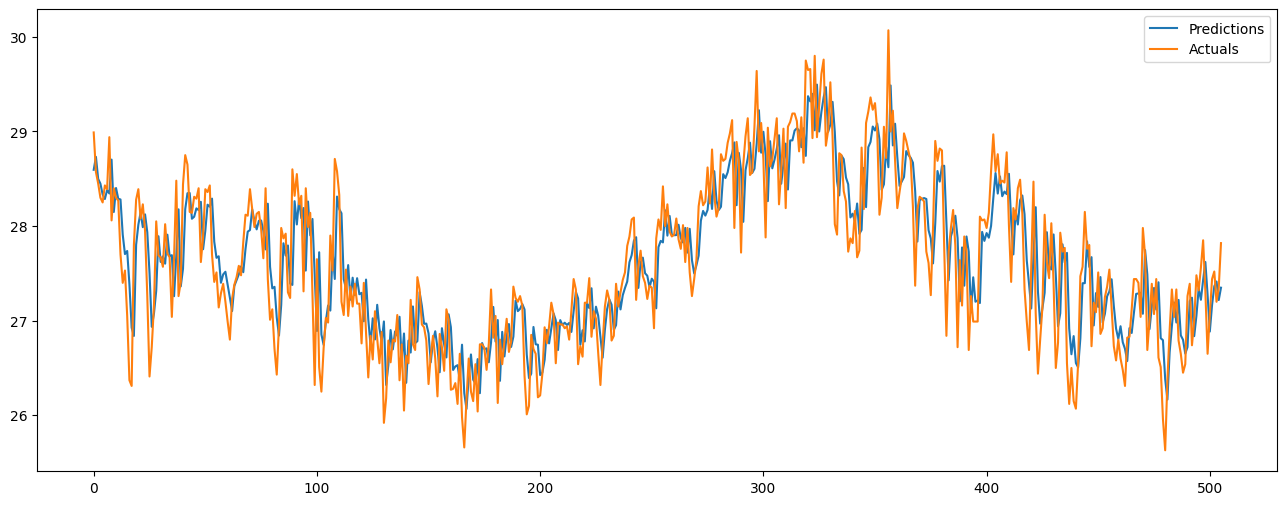

In [71]:
plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

In [72]:
from datetime import timedelta

In [73]:
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [ ]:
future = 365
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0]) 
    print(forcast)
    Xin = insert_end(Xin, out[0, 0]) 
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 [==============================] - 0s 22ms/step
[array([0.56484777], dtype=float32)]
1/1 [==============================] - 0s 24ms/step
[array([0.56484777], dtype=float32), array([0.56640226], dtype=float32)]
1/1 [==============================] - 0s 25ms/step
[array([0.56484777], dtype=float32), array([0.56640226], dtype=float32), array([0.5679411], dtype=float32)]
1/1 [==============================] - 0s 29ms/step
[array([0.56484777], dtype=float32), array([0.56640226], dtype=float32), array([0.5679411], dtype=float32), array([0.56931186], dtype=float32)]
1/1 [==============================] - 0s 30ms/step
[array([0.56484777], dtype=float32), array([0.56640226], dtype=float32), array([0.5679411], dtype=float32), array([0.56931186], dtype=float32), array([0.57054085], dtype=float32)]
1/1 [==============================] - 0s 76ms/step
[array([0.56484777], dtype=float32), array([0.56640226], dtype=float32), array([0.5679411], dtype=float32), array([0.56931186], dtype=float32), ar

In [ ]:
forcasted_output = np.asanyarray(forcast)   
forcasted_output = scaler.inverse_transform(forcasted_output)

In [ ]:
forcasted_output

In [ ]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"
df_result

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Tesla Close Stock Price Forecasting For Next 30 Days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Suhu' ,fontsize=18)
plt.plot(df['Suhu'])
plt.plot(df_result.set_index('Date')[['Forecasted']])

In [ ]:
# Step 1: Filter data aktual tahun 2024
df_2024 = df[df.index.year == 2024]

# Step 2: Gabungkan data aktual tahun 2024 dan hasil forecast
# Data aktual berhenti di akhir tahun 2023, sehingga prediksi forecast dimulai di tahun 2024
combined_forecast = pd.concat([df_2024, df_result], axis=0)

# Step 3: Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(df_2024.index, df_2024.iloc[:, 0], label="Data Aktual Tahun 2024", color='blue')
plt.plot(forecast_df.index, forecast_df['Forecast'], label="Forecast Tahun 2024", color='red')

# Tambahkan judul dan label
plt.title("Prediksi Tahun 2024 Menggunakan LSTM")
plt.xlabel("Tanggal")
plt.ylabel("Nilai")
plt.legend()

# Tampilkan plot
plt.show()

In [24]:
df = df.drop(columns=['Kelembaban', 'Curah_Hujan'])

In [31]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Define sequence length and features
SEQ_LENGTH = 60  # Panjang sequence untuk 1 tahun (harian)
num_features = len(df.columns)  # Jumlah fitur dalam dataset

# Create sequences and corresponding labels
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]  # Ambil window sepanjang seq_length
        label = data[i + seq_length][0]  # Target adalah nilai fitur pertama
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Generate sequences and labels
sequences, labels = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train and test sets
train_size = int(0.9 * len(sequences))
train_x, test_x = sequences[:train_size], sequences[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)
print("Test X shape:", test_x.shape)
print("Test Y shape:", test_y.shape)

Train X shape: (4493, 60, 3)
Train Y shape: (4493,)
Test X shape: (500, 60, 3)
Test Y shape: (500,)


In [38]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Define sequence length and features
sequence_length = 10  # Number of time steps in each sequence
num_features = len(df.columns)

# Create sequences and corresponding labels
def create_sequences(df, seq_length):
    sequences = []
    labels = []
    for i in range(len(scaled_data) - sequence_length):
        seq = scaled_data[i:i+sequence_length]
        label = scaled_data[i+sequence_length][0]  # '_tempm' column index
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

SEQ_LENGTH = 365  # for 24 hours sequence
sequences, labels = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train and test sets
train_size = int(0.9 * len(sequences))
train_x, test_x = sequences[:train_size], sequences[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)
print("Test X shape:", test_x.shape)
print("Test Y shape:", test_y.shape)

Train X shape: (4538, 10, 3)
Train Y shape: (4538,)
Test X shape: (505, 10, 3)
Test Y shape: (505,)


In [32]:


# Create the LSTM model
model = Sequential()

# Add LSTM layers with dropout
model.add(LSTM(units=128, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Add a dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [33]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_x, train_y,
    epochs=100,
    batch_size=64,
    validation_split=0.2,  # Use part of the training data as validation
    callbacks=[early_stopping]
)

Epoch 1/100
57/57 [==============================] - 24s 215ms/step - loss: 0.0219 - val_loss: 0.0101
Epoch 2/100
57/57 [==============================] - 8s 140ms/step - loss: 0.0132 - val_loss: 0.0097
Epoch 3/100
57/57 [==============================] - 8s 142ms/step - loss: 0.0130 - val_loss: 0.0094
Epoch 4/100
57/57 [==============================] - 8s 132ms/step - loss: 0.0120 - val_loss: 0.0093
Epoch 5/100
57/57 [==============================] - 7s 131ms/step - loss: 0.0117 - val_loss: 0.0097
Epoch 6/100
57/57 [==============================] - 8s 133ms/step - loss: 0.0112 - val_loss: 0.0089
Epoch 7/100
57/57 [==============================] - 7s 130ms/step - loss: 0.0114 - val_loss: 0.0089
Epoch 8/100
57/57 [==============================] - 7s 131ms/step - loss: 0.0110 - val_loss: 0.0101
Epoch 9/100
57/57 [==============================] - 6s 104ms/step - loss: 0.0107 - val_loss: 0.0088
Epoch 10/100
57/57 [==============================] - 6s 99ms/step - loss: 0.0098 - val_lo

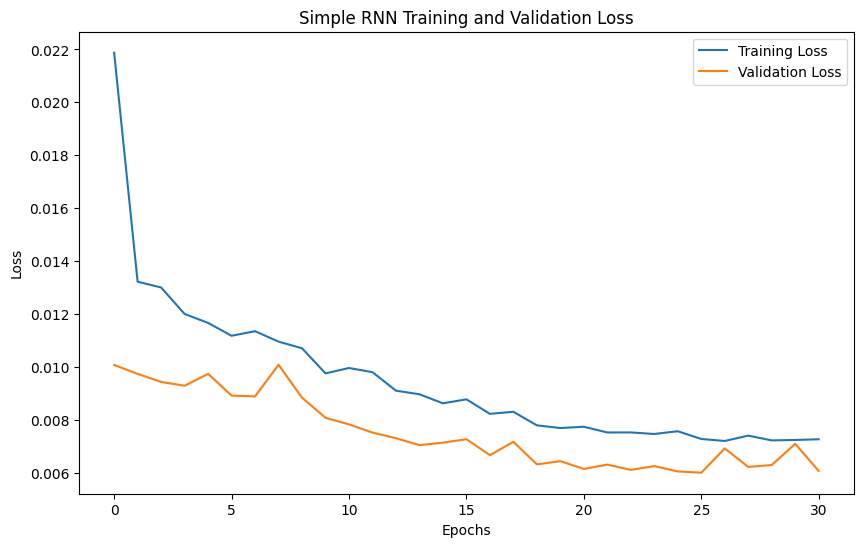

In [34]:
# Simple RNN
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Simple RNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
predictions = model.predict(test_x)

# Calculate evaluation metrics 90:10
mae = mean_absolute_error(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

16/16 [==============================] - 4s 52ms/step
Mean Absolute Error (MAE): 0.06309246496010891
Mean Squared Error (MSE): 0.0062057977271654215
Root Mean Squared Error (RMSE): 0.07877688574172897


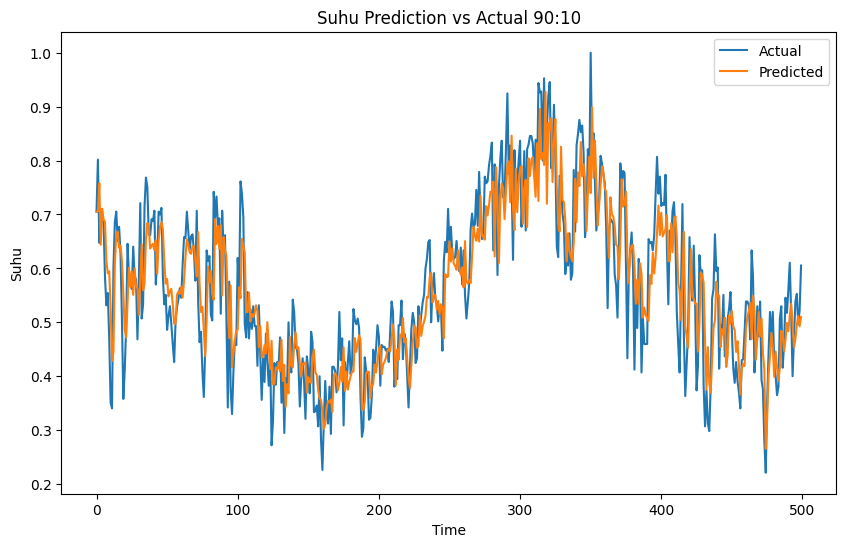

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(test_y, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Suhu Prediction vs Actual 90:10')
plt.xlabel('Time')
plt.ylabel('Suhu')
plt.legend()
plt.show()

In [42]:
# Forecast 365 hari ke depan
forecast_days = 365
forecast = []

# Ambil input terakhir dari dataset (sequences terakhir yang dipakai)
current_sequence = scaled_data[-SEQ_LENGTH:]  # Ambil sequence terakhir

# Iteratif prediksi hari ke depan
for day in range(forecast_days):
    # Prediksi menggunakan model
    prediction = model.predict(current_sequence.reshape(1, SEQ_LENGTH, num_features), verbose=0)
    
    # Simpan hasil prediksi
    forecast.append(prediction[0][0])
    
    # Update sequence: geser ke depan dan tambahkan prediksi
    next_sequence = np.append(current_sequence[1:], [[prediction[0][0]] * num_features], axis=0)
    current_sequence = next_sequence

# Invers transform untuk mengembalikan ke skala aslinya
forecast = scaler.inverse_transform([[val] + [0] * (num_features - 1) for val in forecast])

# Buat dataframe untuk hasil forecast
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='D')
forecast_df = pd.DataFrame(forecast[:, 0], index=forecast_index, columns=['Forecast'])

# Tampilkan hasil prediksi
print(forecast_df)



             Forecast
2024-11-01  27.605730
2024-11-02  26.760594
2024-11-03  26.865978
2024-11-04  26.797409
2024-11-05  26.780507
...               ...
2025-10-27  25.684945
2025-10-28  25.684945
2025-10-29  25.684945
2025-10-30  25.684945
2025-10-31  25.684945

[365 rows x 1 columns]


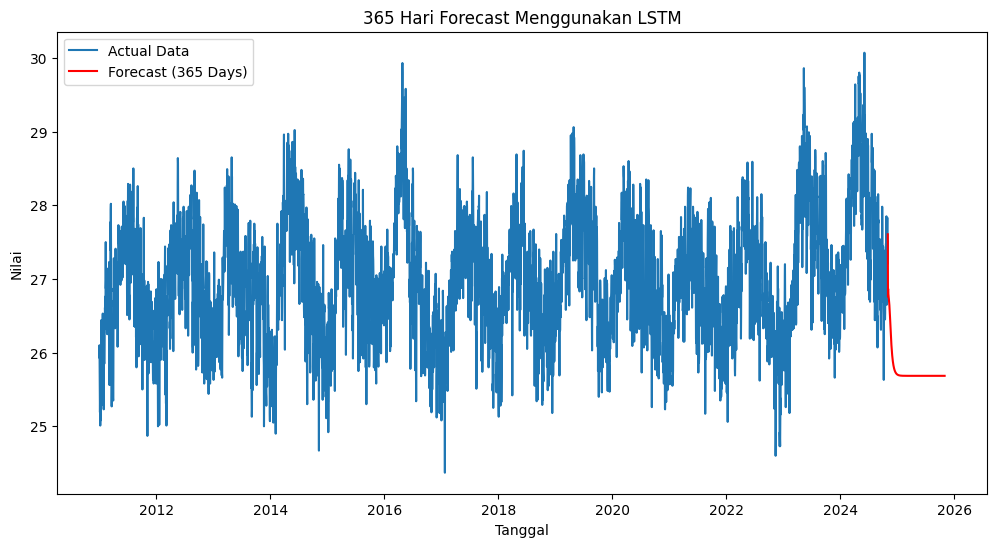

In [41]:
# Visualisasi hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(df.index, df.iloc[:, 0], label="Actual Data")
plt.plot(forecast_df.index, forecast_df['Forecast'], label="Forecast (365 Days)", color='red')
plt.title("365 Hari Forecast Menggunakan LSTM")
plt.xlabel("Tanggal")
plt.ylabel("Nilai")
plt.legend()
plt.show()

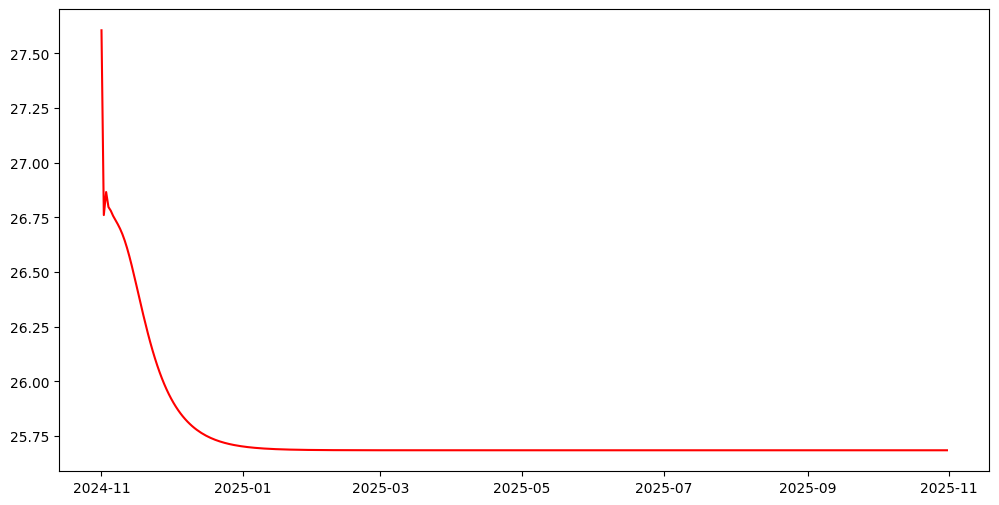

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df['Forecast'], label="Forecast (365 Days)", color='red')

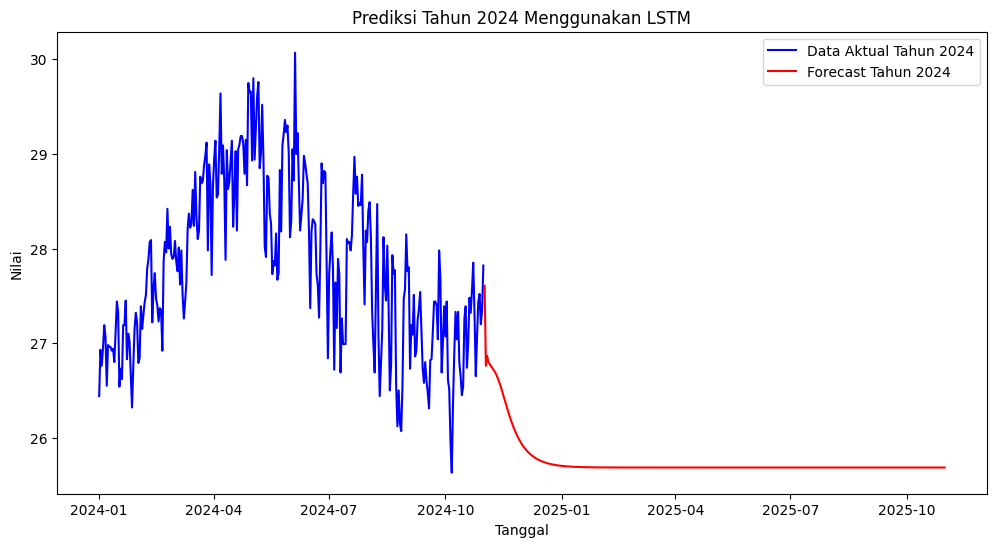

In [44]:
# Step 1: Filter data aktual tahun 2024
df_2024 = df[df.index.year == 2024]

# Step 2: Gabungkan data aktual tahun 2024 dan hasil forecast
# Data aktual berhenti di akhir tahun 2023, sehingga prediksi forecast dimulai di tahun 2024
combined_forecast = pd.concat([df_2024, forecast_df], axis=0)

# Step 3: Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(df_2024.index, df_2024.iloc[:, 0], label="Data Aktual Tahun 2024", color='blue')
plt.plot(forecast_df.index, forecast_df['Forecast'], label="Forecast Tahun 2024", color='red')

# Tambahkan judul dan label
plt.title("Prediksi Tahun 2024 Menggunakan LSTM")
plt.xlabel("Tanggal")
plt.ylabel("Nilai")
plt.legend()

# Tampilkan plot
plt.show()

In [66]:
from datetime import timedelta

In [67]:
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [73]:
future = 365
forcast = []
Xin = test_x[-1 :, :, :]
time = []
for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0, 0]) 
    print(forcast)
    Xin = insert_end(Xin, out[0, 0]) 
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 [==============================] - 0s 109ms/step
[0.5039917]
1/1 [==============================] - 0s 131ms/step
[0.5039917, 0.5039917]
1/1 [==============================] - 0s 115ms/step
[0.5039917, 0.5039917, 0.5039917]
1/1 [==============================] - 0s 117ms/step
[0.5039917, 0.5039917, 0.5039917, 0.5039917]
1/1 [==============================] - 0s 112ms/step
[0.5039917, 0.5039917, 0.5039917, 0.5039917, 0.50399166]
1/1 [==============================] - 0s 112ms/step
[0.5039917, 0.5039917, 0.5039917, 0.5039917, 0.50399166, 0.5039917]
1/1 [==============================] - 0s 122ms/step
[0.5039917, 0.5039917, 0.5039917, 0.5039917, 0.50399166, 0.5039917, 0.50399166]
1/1 [==============================] - 0s 100ms/step
[0.5039917, 0.5039917, 0.5039917, 0.5039917, 0.50399166, 0.5039917, 0.50399166, 0.50399166]
1/1 [==============================] - 0s 110ms/step
[0.5039917, 0.5039917, 0.5039917, 0.5039917, 0.50399166, 0.5039917, 0.50399166, 0.50399166, 0.5039917]
1/1 [====

In [74]:
time

[Timestamp('2024-10-31 00:00:00'),
 Timestamp('2024-11-01 00:00:00'),
 Timestamp('2024-11-02 00:00:00'),
 Timestamp('2024-11-03 00:00:00'),
 Timestamp('2024-11-04 00:00:00'),
 Timestamp('2024-11-05 00:00:00'),
 Timestamp('2024-11-06 00:00:00'),
 Timestamp('2024-11-07 00:00:00'),
 Timestamp('2024-11-08 00:00:00'),
 Timestamp('2024-11-09 00:00:00'),
 Timestamp('2024-11-10 00:00:00'),
 Timestamp('2024-11-11 00:00:00'),
 Timestamp('2024-11-12 00:00:00'),
 Timestamp('2024-11-13 00:00:00'),
 Timestamp('2024-11-14 00:00:00'),
 Timestamp('2024-11-15 00:00:00'),
 Timestamp('2024-11-16 00:00:00'),
 Timestamp('2024-11-17 00:00:00'),
 Timestamp('2024-11-18 00:00:00'),
 Timestamp('2024-11-19 00:00:00'),
 Timestamp('2024-11-20 00:00:00'),
 Timestamp('2024-11-21 00:00:00'),
 Timestamp('2024-11-22 00:00:00'),
 Timestamp('2024-11-23 00:00:00'),
 Timestamp('2024-11-24 00:00:00'),
 Timestamp('2024-11-25 00:00:00'),
 Timestamp('2024-11-26 00:00:00'),
 Timestamp('2024-11-27 00:00:00'),
 Timestamp('2024-11-

In [75]:
forcasted_output = np.asanyarray(forcast)   
forcasted_output = forcasted_output.reshape(-1, 1) 
forcasted_output = scaler.inverse_transform(forcasted_output) 

In [76]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"

In [77]:
df_result

Date  Forecasted
0   2024-10-31   27.242754
1   2024-11-01   27.242754
2   2024-11-02   27.242754
3   2024-11-03   27.242754
4   2024-11-04   27.242754
..         ...         ...
360 2025-10-26   27.242754
361 2025-10-27   27.242754
362 2025-10-28   27.242754
363 2025-10-29   27.242754
364 2025-10-30   27.242754

[365 rows x 2 columns]

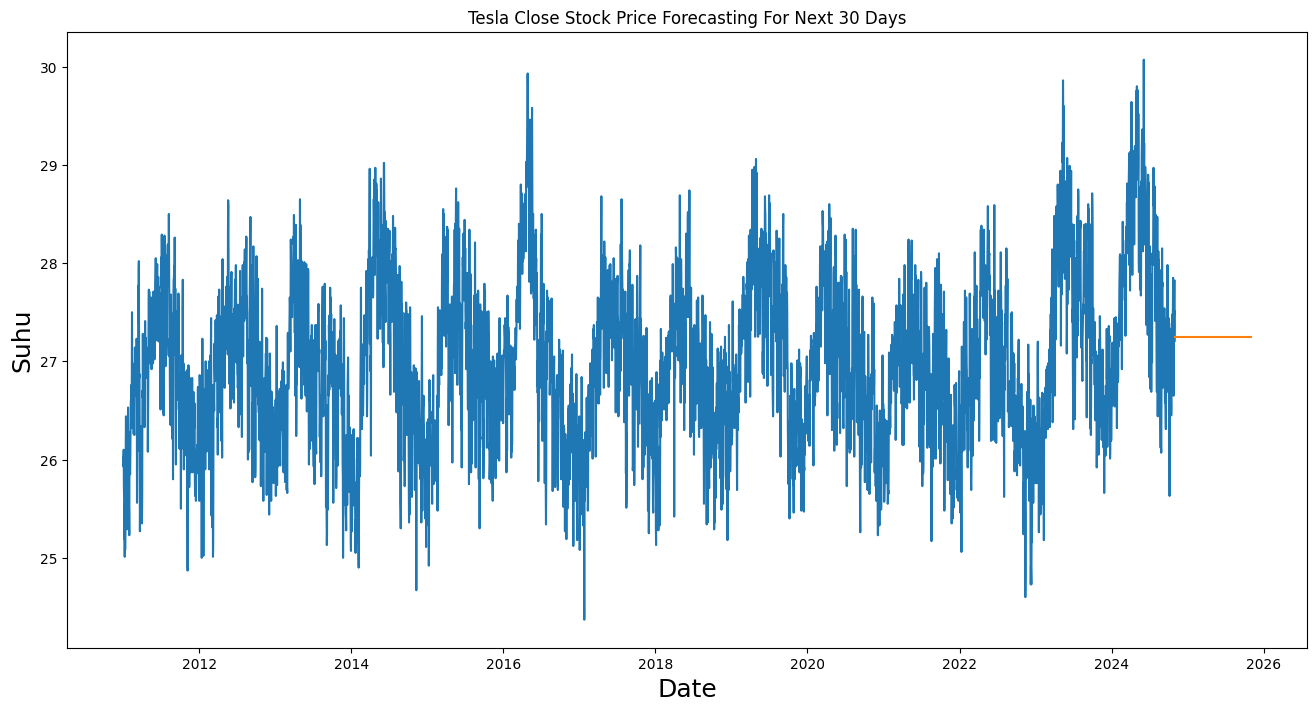

In [78]:
plt.figure(figsize=(16, 8))
plt.title('Tesla Close Stock Price Forecasting For Next 30 Days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Suhu' ,fontsize=18)
plt.plot(df['Suhu'])
plt.plot(df_result.set_index('Date')[['Forecasted']])

In [58]:
# Pastikan forecasted_output berbentuk array dan memiliki dimensi (n, 1)
forcasted_output = np.asarray(forcasted_output)
forcasted_output = forcasted_output.reshape(-1, 1)

# Tambahkan dua kolom dummy untuk mencocokkan jumlah kolom dengan yang diharapkan scaler
dummy_columns = np.zeros((forcasted_output.shape[0], 2))  # Dua kolom dengan nilai nol
forcasted_output_full = np.hstack([forcasted_output, dummy_columns])

# Inverse transformasi
inversed_output_full = scaler.inverse_transform(forcasted_output_full)

# Ambil hanya kolom pertama (suhu) dari hasil inverse transformasi
inversed_output = inversed_output_full[:, 0]

# Hasil inversed_output akan berisi suhu dalam skala asli
print(inversed_output)

[27.25752908 27.25752908 27.25752908 27.25752908 27.25752908 27.25752908
 27.25752908 27.25752908 27.25752908 27.25752908 27.25752908 27.25752874
 27.25752908 27.25752908 27.25752908 27.25752908 27.25752908 27.25752908
 27.25752908 27.25752908 27.25752908 27.25752908 27.25752908 27.25752908
 27.25752908 27.25752908 27.25752908 27.25752908 27.25752908 27.25752908]


In [27]:
# 3. Menyiapkan input untuk prediksi
lookback = 10  # Jumlah hari sebelumnya digunakan untuk prediksi, sesuaikan dengan model Anda
last_sequence = scaled_data[-lookback:]  # Mengambil data terakhir sebagai input

predictions = []

# 4. Prediksi iteratif 365 hari ke depan
for _ in range(365):
    # Tambahkan dimensi batch untuk input ke model
    input_data = last_sequence[-lookback:].reshape(1, lookback, 1)
    
    # Prediksi langkah berikutnya
    next_prediction = model.predict(input_data)
    
    # Simpan prediksi
    predictions.append(next_prediction[0, 0])
    
    # Tambahkan prediksi ke data input untuk prediksi iteratif
    last_sequence = np.append(last_sequence, [[next_prediction[0, 0]]], axis=0)

# 5. Invers transformasi prediksi ke skala asli
predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# 6. Membuat DataFrame untuk hasil prediksi
future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=365)
predicted_df = pd.DataFrame(data=predicted_values, index=future_dates, columns=['Predicted_Suhu'])

# Menampilkan hasil prediksi
print(predicted_df)

ValueError: cannot reshape array of size 30 into shape (1,10,1)

In [25]:
lookback = 30  # Ganti nilai ini sesuai dengan konfigurasi model
last_sequence = scaled_data[-lookback:]  # Ambil data terakhir dengan ukuran lookback

In [28]:
lookback = 30  # Pastikan nilai ini sama dengan saat model dilatih
last_sequence = scaled_data[-lookback:]  # Ambil data terakhir untuk prediksi

predictions = []

# Prediksi iteratif 365 hari ke depan
for _ in range(365):
    # Tambahkan dimensi batch untuk input ke model
    input_data = last_sequence.reshape(1, lookback, 1)
    
    # Prediksi langkah berikutnya
    next_prediction = model.predict(input_data)
    
    # Simpan prediksi
    predictions.append(next_prediction[0, 0])
    
    # Tambahkan prediksi ke data input untuk prediksi iteratif
    last_sequence = np.append(last_sequence, [[next_prediction[0, 0]]], axis=0)
    last_sequence = last_sequence[-lookback:]  # Hanya simpan data ukuran lookback


ValueError: cannot reshape array of size 90 into shape (1,30,1)

In [29]:
lookback = 30  # Sesuaikan dengan model Anda
last_sequence = scaled_data[-lookback:]  # Ambil data terakhir dengan panjang lookback

predictions = []

# Prediksi iteratif 365 hari ke depan
for _ in range(365):
    # Pastikan input memiliki dimensi yang benar
    input_data = last_sequence.reshape(1, lookback, 1)
    
    # Prediksi langkah berikutnya
    next_prediction = model.predict(input_data)
    
    # Simpan prediksi
    predictions.append(next_prediction[0, 0])
    
    # Tambahkan prediksi ke sequence dan potong agar sesuai ukuran lookback
    last_sequence = np.append(last_sequence, next_prediction[0, 0])
    last_sequence = last_sequence[-lookback:]  # Hanya simpan data terakhir sesuai lookback


ValueError: cannot reshape array of size 90 into shape (1,30,1)